In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
### To measure execution time (this method might not be very accurate, use with precaution)
#start = time.clock()
### "Instructions"
#elapsed = time.clock()
#print(f'{elapsed - start}')

In [101]:
## Standard :

# Name imports :
import os
import gc
import copy
import sklearn
import itertools
import time
import typing
import random

# Aliased imports :
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt

# Partial imports :
from scipy.integrate import quad as integrate
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVR
from sklearn import preprocessing

# Full imports :
from plotnine import *

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
sb.set_style("dark")

In [4]:
def split(arr: list, count: int) -> typing.List[list]:
    return [arr[i::count] for i in range(count)]

def overlapping_histograms(df: pd.core.frame.DataFrame, 
                           columns: typing.List[str], 
                           names=None, 
                           colors: typing.List[str]=None,
                           labels: typing.Tuple[str]=None
                          ) -> bool:
    """ Create a figure with overlapping histograms and KDEs from 
    a dataframe's specified columns.
    
    df : A pandas.core.frame.DataFrame
    columns : Names of the columns that will be used to construct the histograms.
    names :  Used to label each histogram and KDE, defaults to 'columns'.
    colors :  A list of colors for the histograms. See sb.xkcd_rgb for available colors.
    labels : A tuple containing ('Plot Title', 'xlabel', 'ylabel' )
    
    Returns: 
        True uppon success
        False uppon an error i.e. 
                One of the specified columns isn't found
                on df.columns
    """
    for col in columns:
        if not (col in df.columns):
            return False
    
    if not names:
        names = columns
    
    if not colors:
        colors = [random.choice(list(sb.xkcd_rgb.values())) for i in range(len(columns))]
    
    for column, name, color in zip(columns, names, colors):
        sb.distplot(
            raw[column].dropna(), 
            kde_kws={"color":color,"lw":2,"label":name,"alpha":0.6}, 
            hist_kws={"color":color,"alpha":0.25}
        )
    
    if labels:
        plt.title(labels[0])
        plt.xlabel(labels[1])
        plt.ylabel(labels[2])
    
    return True
    

def select_date_range(df: pd.core.frame.DataFrame, 
                     start_date: str, 
                     end_date: str) -> pd.core.frame.DataFrame:
    """
    """
    mask = (df.index >= start_date) & (df.index <= end_date)
    
    

def time_indexed_df(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Cast into a time-indexed dataframe.
    df1 paramater should contain a column called 'dateTime',
    which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
    """
    _tmp = copy.deepcopy(df1)
    _tmp.index = df1.dateTime
    _tmp.drop('dateTime', axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    gc.collect()
    return _tmp

def merge_date_time(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Take a dataframe containing columns:
        'Date'
        'Time'
        
        And return one containing a single column:
         'dateTime' = 'Date' + 'Time'
        
        For each entry as seen below:
         '2019-03-21 17:34:05' <- '2019-03-21' + '17:34:05'
    """
    _tmp = copy.deepcopy(df1)
    _tmp['dateTime'] = _tmp['Date'] + ' ' + _tmp['Time']
    _tmp.drop(['Date', 'Time'], axis=1, inplace=True)
    gc.collect()
    return _tmp

def hybrid_interpolator(data: pd.core.series.Series,
                        mean: float = None,
                        limit: float = None,
                        methods: typing.List[str] = ['linear', 'spline'], 
                        weights: typing.List[float] = [0.65, 0.35],
                        direction: str = 'forward',
                        order: int = 2
                       ) -> pd.core.series.Series:
    """
    Return a pandas.core.series.Series instance resulting of the weighted average
    of two interpolation methods.
    
    Model:
        φ = β1*method1 + β2*method2
        
    Default:
        β1, β2 = 0.6, 0.4
        method1, method2 = linear, spline
    
    Weights are meant to be numbers from the interval (0, 1)
    which add up to one, to keep the weighted sum consistent.
    
    limit_direction : {‘forward’, ‘backward’, ‘both’}, default ‘forward’
    If limit is specified, consecutive NaNs will be filled in this direction.
    
    If the predicted φ_i value is outside of the the interval
    ( (mean - limit), (mean + limit) )
    it will be replaced by the linear interpolation approximation.
    
    If not set, mean and limit will default to:
        mean = data.mean()
        limit = 2 * data.std()
    
    This function should have support for keyword arguments, but is yet to be implemented.
    """
    predictions: typing.List[float] = [] 
    
    if not np.isclose(sum(weight for weight in weights), 1):
        raise Exception('Sum of weights must be equal to one!')
    
    for met in methods:
        if (met == 'spline') or (met == 'polynomial'):
            predictions.append(data.interpolate(method=met, order=order, limit_direction=direction))
        else:
            predictions.append(data.interpolate(method=met, limit_direction=direction))

    linear: pd.core.series.Series = predictions[0]
    spline: pd.core.series.Series = predictions[1]
    hybrid: pd.core.series.Series = weights[0]*predictions[0] + weights[1]*predictions[1]
    
    corrected: pd.core.series.Series = copy.deepcopy(hybrid) 
    
    if not mean:
        mean = data.mean()
    if not limit:
        limit = 2 * data.std()
    
    for idx, val in zip(hybrid[ np.isnan(data) ].index, hybrid[ np.isnan(data) ]):
        if (val > mean + limit) or (val < mean - limit):
            corrected[idx] = linear[idx]
    
    #df = copy.deepcopy(interpolated)
    #print(df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum())
    
    return corrected
    
    
def naive_hybrid_interpolator(data: pd.core.series.Series, 
                        methods: typing.List[str] = ['linear', 'spline'], 
                        weights: typing.List[float] = [0.85, 0.15],
                        direction: str = 'both',
                        order: int = 2
                       ) -> pd.core.series.Series:
    """
    Return a pandas.core.series.Series instance resulting of the weighted average
    of two interpolation methods.
    
    Model:
        φ = β1*method1 + β2*method2
        
    Default:
        β1, β2 = 0.6, 0.4
        method1, method2 = linear, spline
    
    limit_direction : {‘forward’, ‘backward’, ‘both’}, default ‘forward’
    If limit is specified, consecutive NaNs will be filled in this direction.
    
    This function should have support for keyword arguments, but is yet to be implemented.
    """
    predictions: typing.List[float] = [] 
    
    if sum(weight for weight in weights) > 1:
        raise Exception('Sum of weights must be equal to one!')
    
    for met in methods:
        if (met == 'spline') or (met == 'polynomial'):
            predictions.append(data.interpolate(method=met, order=order, limit_direction=direction))
        else:
            predictions.append(data.interpolate(method=met, limit_direction=direction))

    #linear = predictions[0]
    #spline = predictions[1]
    
    #print(linear[ np.isnan(data) ])
    
    # working version:
    interpolated = weights[0]*predictions[0] + weights[1]*predictions[1]
    
    #df = copy.deepcopy(interpolated)
    #print(df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum())
    
    return interpolated
    

def probability_estimate(data: pd.core.series.Series, 
                         start: float, 
                         end: float, 
                         N: int = 150,
                         show_plots=False) -> float:
    """
    """
    
    # Plot the data using a normalized histogram
    dev = copy.deepcopy(data)
    dev = dev.dropna()
    x = np.linspace(dev.min(), min(data), max(data))[:, np.newaxis]

    # Do kernel density estimation
    kd = KernelDensity(kernel='gaussian', bandwidth=0.85).fit(np.array(dev).reshape(-1, 1))

    # Plot the estimated densty
    kd_vals = np.exp(kd.score_samples(x))

    # Show the plots
    if show_plots:
        plt.plot(x, kd_vals)
        plt.hist(dev, 50, normed=True)
        plt.xlabel('Concentration mg/dl')
        plt.ylabel('Density')
        plt.title('Probability Density Esimation')
        plt.show()

    #probability = integrate(lambda x: np.exp(kd.score_samples(x.reshape(-1, 1))), start, end)[0]
    
    # Integration :
    step = (end - start) / (N - 1)  # Step size
    x = np.linspace(start, end, N)[:, np.newaxis]  # Generate values in the range
    kd_vals = np.exp(kd.score_samples(x))  # Get PDF values for each x
    probability = np.sum(kd_vals * step)  # Approximate the integral of the PDF
    
    return probability


def dev_from_mean(data: pd.core.series.Series) -> typing.Tuple[float, pd.core.series.Series, float]:
    """
    Returns (mean, abs_deviations, avg_of_devs)
    
        mean: float = the mean of the sample
        
        abs_deviations: pandas.core.series.Series = absoulute value of deviations from the mean
        
        avg_of_devs: float = mean of the absolute value of deviations.
    """
    _mean: float = data.mean()
    _std: float = data.std()
    _devs: pd.core.series.Series = np.abs(data - _mean)
    _avg_dev_mean: float = _devs.mean()
        
    return _mean, _std, _devs, _avg_dev_mean


def porcentage_original(serie: pd.core.series.Series, start: str, stop: str) -> float:
    return serie[start:stop].count() / len(serie.loc[start:stop])
    
    
def porcentage_interpolated(serie: pd.core.series.Series, start: str, stop: str) -> float:
    return 1 - porcentage_original(serie, start, stop)


In [5]:
raw = pd.read_csv('data/carelink2.csv')

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,8,9,10,13,14,16,17,18,32,34,37,39,41,42,44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
raw = merge_date_time(raw)

In [9]:
# Remove ['MiniMed 640G MMT-1512/1712 Sensor', 'Date Time'] from the column, 
# as they impede coercing the values into timestamps.
for row in filter(lambda x: False if ':' in x else True, raw['dateTime'] ):
    raw = raw[raw.dateTime != row]

In [10]:
pool = mp.Pool() # processes parameter can be set manually, 
                 # but this is suposed to spawn the same number as the system has cores.

raw.dateTime = pool.map(pd.to_datetime, raw.dateTime)

pool.close()
pool.terminate()

In [11]:
undesired_columns = [
    'Index',
    'Temp Basal Type', 
    'Temp Basal Duration (h:mm:ss)',
    'BWZ Target High BG (mg/dL)', 
    'BWZ Target Low BG (mg/dL)',
    'Bolus Type',
    'Insulin Action Curve Time',
    'New Device Time',
    'Bolus Duration (h:mm:ss)',
    'Prime Type', 
    'Prime Volume Delivered (U)',
    'Alarm',
    'ISIG Value',
    'Event Marker',
    'Bolus Number',
    'Suspend', 
    'Rewind',
    'Linked BG Meter ID',
    'Bolus Cancellation Reason',
    'Scroll Step Size',
    'Sensor Calibration Rejected Reason',
    'Network Device Associated Reason',
    'Network Device Disassociated Reason',
    'Network Device Disconnected Reason',
    'Sensor Exception',
    'Preset Temp Basal Name',
    'Preset Bolus', 
    'Bolus Source'
]

In [12]:
raw = raw.drop(undesired_columns, axis=1)

In [14]:
unsure_columns = [
    'BG Reading (mg/dL)',
    'Sensor Calibration BG (mg/dL)'
]

In [15]:
proc1 = raw.drop(unsure_columns, axis=1)

In [16]:
proc1 = time_indexed_df(proc1)

In [17]:
proc1 = proc1.iloc[2:, :]

In [18]:
# Cutoff seconds so that measurements are not lost when interpolating.
proc1.index = proc1.index .map(lambda t: t.replace(second=0))

True

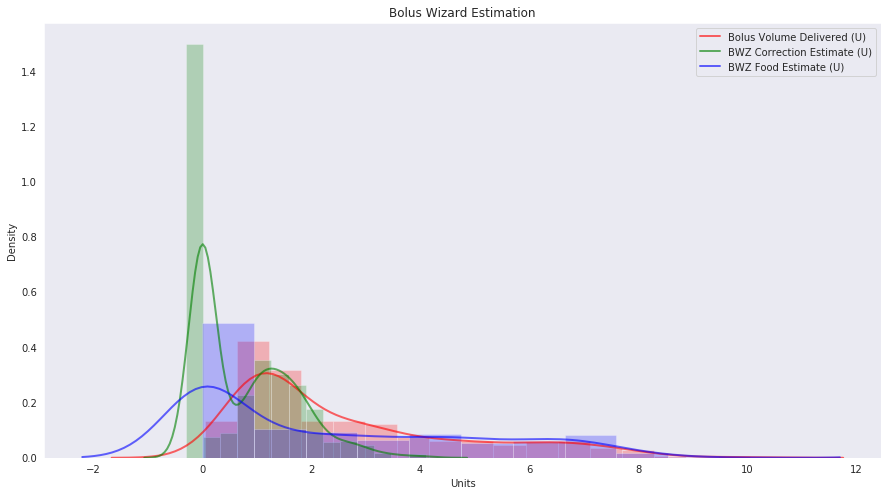

In [19]:
overlapping_histograms(proc1, 
                       ['Bolus Volume Delivered (U)', 'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)'],
                       colors=['red', 'green', 'blue'], 
                       labels=('Bolus Wizard Estimation', 'Units', 'Density')
                      )

In [20]:
proc2 = proc1.copy()

In [21]:
def resample_dataframe(_df : pd.core.frame.DataFrame,
         interpolation : bool = False,
         resample_freq : str  = '1T') -> pd.core.frame.DataFrame:
    '''
        Resamples
    '''

    df = _df.copy()
    df = df.resample(resample_freq).mean()
    #_index = df.index
    
    if interpolation:
        df['Sensor Glucose (mg/dL)'] = df['Sensor Glucose (mg/dL)'].interpolate(method='linear')
        #df['Basal Rate (U/h)'] = df['Basal Rate (U/h)'].interoplate(method='pad')
  
    return df

In [22]:
len(proc1.index), len(proc1.index.get_duplicates())

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """Entry point for launching an IPython kernel.


(96128, 5487)

In [23]:
dummy = proc1.copy()
dummy['_grouper'] = dummy.index
dummy = dummy.groupby('_grouper').max().reset_index()
dummy.index = dummy['_grouper']
dummy = dummy.drop('_grouper', axis=1)

In [28]:
# SuperSlow execution! Cell
dummy['Sensor Glucose (mg/dL)'] = hybrid_interpolator(dummy['Sensor Glucose (mg/dL)'])

In [29]:
dummy = dummy.loc['2018/06/24':'2019/04/23']

In [30]:
#help(dummy.dropna)
dummy['Sensor Glucose (mg/dL)'].count() / len(dummy['Sensor Glucose (mg/dL)'])

1.0

In [31]:
data = dummy.dropna(axis='columns')

In [32]:
X = np.array(data.index)
X = X.reshape(-1, 1)
y = np.array(data)
y = y.flatten()

In [33]:
np.savetxt('data/X.np', X)
np.savetxt('data/y.np', y)

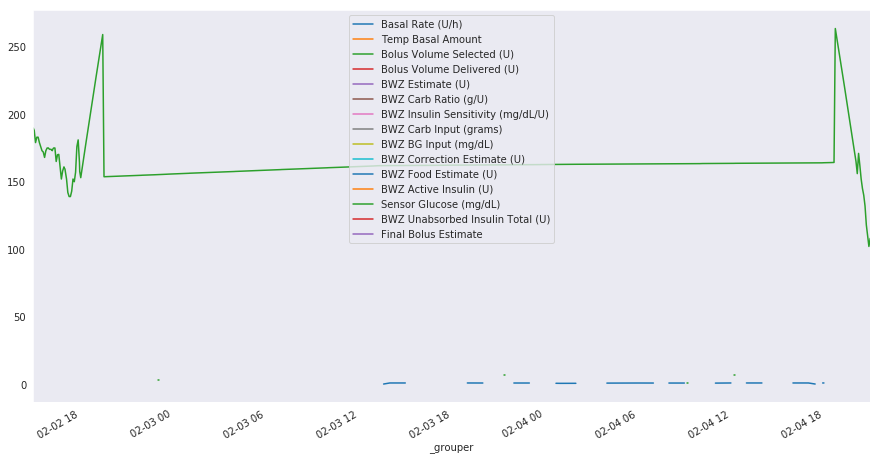

In [34]:
dummy.loc['2019/02/02 15':'2019/02/04 20'].plot()

In [38]:
first_half = data.loc['2019/01/01':'2019/02/02 15']

In [39]:
second_half = data.loc['2019/02/04 20':data.index[-1]]

In [40]:
first_half_resampled = resample_dataframe(first_half, interpolation=True)

In [41]:
second_half_resampled = resample_dataframe(second_half, interpolation=True)

In [42]:
def nn_format_df(    df : pd.core.frame.DataFrame,\
                  order : str = 'first'           ) -> pd.core.frame.DataFrame:
  ''' Take a DataFrame with n columns and return a DataFrame with 
  m*n columns containing the information of those three original columns
  within the next 0:30, 1, 1:30, 2, 2:30, 2:45, and 3 hours (depending on the order).
    order:
      'first'  = 1, 2, and 3 hours.
      'second' = 1, 2, 2:45, and 3 hours.
      'third'  = 0:30, 1, 1:30, 2, 2:30, 2:45, and 3 hours.
  '''
  _df : pd.core.frame.DataFrame = df.copy()
  if order == 'first':
    _df = pd.concat([_df,\
                     _df.shift( -60).rename(columns=dict((elem, elem+'1') for elem in df.columns)),\
                     _df.shift(-120).rename(columns=dict((elem, elem+'2') for elem in df.columns)),\
                     _df.shift(-180).rename(columns=dict((elem, elem+'3') for elem in df.columns))],\
                      axis=1)
  elif order == 'second':
    _df = pd.concat([_df,\
                   _df.shift( -60).rename(columns=dict((elem, elem+'1') for elem in df.columns)),\
                   _df.shift(-120).rename(columns=dict((elem, elem+'2') for elem in df.columns)),\
                   _df.shift(-165).rename(columns=dict((elem, elem+'2:45') for elem in df.columns)),\
                   _df.shift(-180).rename(columns=dict((elem, elem+'3') for elem in df.columns))],\
                    axis=1)
  elif order == 'third':
    _df = pd.concat([_df,\
                   _df.shift( -15).rename(columns=dict((elem, elem+'+ 0:15') for elem in df.columns)),\
                   _df.shift( -30).rename(columns=dict((elem, elem+'+ 0:30') for elem in df.columns)),\
                   _df.shift( -45).rename(columns=dict((elem, elem+'+ 0:45') for elem in df.columns)),\
                   _df.shift( -60).rename(columns=dict((elem, elem+'+ 1:00') for elem in df.columns)),\
                   _df.shift( -75).rename(columns=dict((elem, elem+'+ 1:15') for elem in df.columns)),\
                   _df.shift( -90).rename(columns=dict((elem, elem+'+ 1:30') for elem in df.columns)),\
                   _df.shift(-105).rename(columns=dict((elem, elem+'+ 1:45') for elem in df.columns)),\
                   _df.shift(-120).rename(columns=dict((elem, elem+'+ 2:00') for elem in df.columns)),\
                   _df.shift(-180).rename(columns=dict((elem, elem+'+ 3:00') for elem in df.columns))],\
                    axis=1)
  elif order == 'naive':
    _df = pd.concat([_df,\
                   _df.shift( -30).rename(columns=dict((elem, elem+'0:30') for elem in df.columns)),\
                   _df.shift( -60).rename(columns=dict((elem, elem+'1') for elem in df.columns)),\
                   _df.shift( -90).rename(columns=dict((elem, elem+'1:30') for elem in df.columns)),\
                   _df.shift(-120).rename(columns=dict((elem, elem+'2') for elem in df.columns)),\
                   _df.shift(-150).rename(columns=dict((elem, elem+'2:30') for elem in df.columns)),\
                   _df.shift(-165).rename(columns=dict((elem, elem+'2:45') for elem in df.columns)),\
                   _df.shift(-180).rename(columns=dict((elem, elem+'3') for elem in df.columns))],\
                    axis=1)
  else:
    printf('Error, order {order} is not valid. \n Options are: \'first\', \'second\', or \'third\' \n')
    _df = None

  return _df

In [ ]:
def svr_format_df(    df : pd.core.frame.DataFrame,\
                  order : str = 'first'           ) -> pd.core.frame.DataFrame:
  ''' Take a DataFrame with n columns and return a DataFrame with 
  m*n columns containing the information of those three original columns
  within the next 0:30, 1, 1:30, 2, 2:30, 2:45, and 3 hours (depending on the order).
    order:
      'first'  = 1, 2, and 3 hours.
      'second' = 1, 2, 2:45, and 3 hours.
      'third'  = 0:30, 1, 1:30, 2, 2:30, 2:45, and 3 hours.
  '''
  _df : pd.core.frame.DataFrame = df.copy()
  if order == 'first':
    _df = pd.concat([_df,\
                     _df.shift( -60).rename(columns=dict((elem, elem+'1') for elem in df.columns)),\
                     _df.shift(-120).rename(columns=dict((elem, elem+'2') for elem in df.columns)),\
                     _df.shift(-180).rename(columns=dict((elem, elem+'3') for elem in df.columns))],\
                      axis=1)
  elif order == 'second':
    _df = pd.concat([_df,\
                   _df.shift( -60).rename(columns=dict((elem, elem+'1') for elem in df.columns)),\
                   _df.shift(-120).rename(columns=dict((elem, elem+'2') for elem in df.columns)),\
                   _df.shift(-165).rename(columns=dict((elem, elem+'2:45') for elem in df.columns)),\
                   _df.shift(-180).rename(columns=dict((elem, elem+'3') for elem in df.columns))],\
                    axis=1)
  elif order == 'third':
    _df = pd.concat([_df,\
                   _df.shift( -15).rename(columns=dict((elem, elem+'+ 0:15') for elem in df.columns)),\
                   _df.shift( -30).rename(columns=dict((elem, elem+'+ 0:30') for elem in df.columns)),\
                   _df.shift( -45).rename(columns=dict((elem, elem+'+ 0:45') for elem in df.columns)),\
                   _df.shift( -60).rename(columns=dict((elem, elem+'+ 1:00') for elem in df.columns)),\
                   _df.shift( -75).rename(columns=dict((elem, elem+'+ 1:15') for elem in df.columns)),\
                   _df.shift( -90).rename(columns=dict((elem, elem+'+ 1:30') for elem in df.columns)),\
                   _df.shift(-105).rename(columns=dict((elem, elem+'+ 1:45') for elem in df.columns)),\
                   _df.shift(-120).rename(columns=dict((elem, elem+'+ 2:00') for elem in df.columns)),\
                   _df.shift(-180).rename(columns=dict((elem, elem+'+ 3:00') for elem in df.columns))],\
                    axis=1)
  elif order == 'naive':
    _df = pd.concat([_df,\
                   _df.shift( -30).rename(columns=dict((elem, elem+'0:30') for elem in df.columns)),\
                   _df.shift( -60).rename(columns=dict((elem, elem+'1') for elem in df.columns)),\
                   _df.shift( -90).rename(columns=dict((elem, elem+'1:30') for elem in df.columns)),\
                   _df.shift(-120).rename(columns=dict((elem, elem+'2') for elem in df.columns)),\
                   _df.shift(-150).rename(columns=dict((elem, elem+'2:30') for elem in df.columns)),\
                   _df.shift(-165).rename(columns=dict((elem, elem+'2:45') for elem in df.columns)),\
                   _df.shift(-180).rename(columns=dict((elem, elem+'3') for elem in df.columns))],\
                    axis=1)
  else:
    printf('Error, order {order} is not valid. \n Options are: \'first\', \'second\', or \'third\' \n')
    _df = None

  return _df

In [43]:
hola = nn_format_df(first_half_resampled).dropna(how='any')

In [44]:
adios = nn_format_df(second_half_resampled).dropna(how='any')

In [45]:
hola.to_csv('binaries/first_half_resampled.csv')

In [46]:
adios.to_csv('binaries/second_half_resampled.csv')

In [48]:
#adios

In [49]:
def predict_values(dates, prices, x):
    dates = np.reshape(dates, (len(dates), 1))
    
    svrs = {
        'linear': SVR(kernel='linear', C=1e3), 
        'poly': SVR(kernel='poly', C=1e3, degree=2), 
        'rbf': SVR(kernel='rbf', C=1e3, gamma=0.1)
    }
    
    [ svrs[key].fit(dates, prices) for key in svrs.keys() ]
    

In [50]:
str(dummy.index[0]).split('-')[2]

'24 00:00:00'

In [51]:
def predict_prices(dates, prices, x):
    dates = np.reshape(dates,(len(dates), 1)) # convert to 1xn dimension
    x = np.reshape(x,(len(x), 1))
    
    svr_lin  = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=2)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    
    # Fit regression model
    svr_lin .fit(dates, prices)
    svr_poly.fit(dates, prices)
    svr_rbf.fit(dates, prices)
    
    plt.scatter(dates, prices, c='k', label='Data')
    plt.plot(dates, svr_lin.predict(dates), c='g', label='Linear model')
    plt.plot(dates, svr_rbf.predict(dates), c='r', label='RBF model')    
    plt.plot(dates, svr_poly.predict(dates), c='b', label='Polynomial model')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()
    
    return svr_rbf.predict(x)[0], svr_lin.predict(x)[0], svr_poly.predict(x)[0]


In [173]:
#def predict_prices(dates, prices, x):
#    dates = np.reshape(dates,(len(dates), 1)) # convert to 1xn dimension
#    x = np.reshape(x,(len(x), 1))

class SVRegressor(object):
    
    def __init__(self, 
                 C: float = 1e3, 
                 degree: int = 2, 
                 gamma: float = 0.1,
                 X: np.ndarray = None,
                 y: np.ndarray = None,
                 features: str = 'X',
                 labels: str = 'y'
                ):
        self._keys = ['linear', 'poly', 'rbf']   
        self._svrs = {
            'linear': SVR(kernel='linear', C=C), 
            'poly': SVR(kernel='poly', C=C, degree=degree), 
            'rbf': SVR(kernel='rbf', C=C, gamma=gamma)
        }
        self._labels = {
            'features': features, 
            'labels': labels
        }
        if X is not None and y is not None:
            if type(X) is np.ndarray and type(y) is np.ndarray:
                self._X = X
                self._y = y
            else:
                raise Exception('type() X and y should be numpy.ndarray')
        else:
            self._X = X
            self._y = y
    ##
    
    def __getitem__(self, key):
        if key in self.keys:
            return self._svrs[key]
        else:
            raise Exception(f'{key} not found in keys. Possible values are: {self.keys}')
    ##
    
    @property
    def keys(self):
        return self._keys
    ##
    
    @property
    def kernels(self):
        return self._keys
    ##
    
    def set_training_data(self, X, y):
        if type(X) is np.ndarray and type(y) is np.ndarray:
            self._X = X
            self._y = y
        else:
            raise Exception('type() X and y should be numpy.ndarray')
    ##
    
    @property
    def training_data(self):
        ''' Returns self._X (features), self._y (labels)'''
        return self._X, self._y
    ##
    
    def fit(self, kernel: str = 'all'):
        if kernel == 'all':
            [ self._svrs[i].fit(self._X, self._y) for i in self.keys ]
        elif kernel in self.kernels:
            self._svrs[kernel].fit(self._X, self._y)
        else:
            raise Exception(f'Invalid kernel, available kernels are {self.kernels}')
    ##
            
    def plot_training(self, kernel: str = 'all', 
                      xlabel: str = 'X', ylabel: str = 'y'):
        
        if kernel == 'all':
            if len(self._X.shape) == 1:
                plt.scatter(self._X, self._y, c='k', label='Data')
                for key, color in zip(self._svrs.keys(), ['g', 'r', 'b']):
                    plt.plot(self._X, self._svrs[key].predict(self._X), c=color, label=key)
            else:
                _dummy_x = [i for i in range(len(self._y))]
                plt.scatter(_dummy_x, self._y, c='k', label='Data')
                for i, key, color in zip(range(3), self._svrs.keys(), ['g', 'r', 'b']):
                    plt.plot(_dummy_x, self._svrs[key].predict(self._X), c=color, label=key)
        
        elif kernel in self.kernels:
            if len(self._X.shape) == 1:
                plt.scatter(self._X, self._y, c='k', label='Data')
                plt.plot(self._X, self._svrs[kernel].predict(self._X), c='g', label=kernel)
            else:
                _dummy_x = [i for i in range(len(self._y))]
                plt.scatter(_dummy_x, self._y, c='k', label='Data')
                plt.plot(_dummy_x, self._svrs[kernel].predict(self._X), c='g', label=kernel)
        
        else:
            raise Exception(f'Invalid kernel, available kernels are {self.kernels}')
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title('Support Vector Regression')
        plt.legend()
        plt.show()
    ##
    
    def metrics(self, kernel: str = 'all',
                X: np.ndarray, y: np.ndarray):
        if kernel == 'all':
            predictions = { 
                kernel: self._svrs[kernel].predict(X) for kernel in self.kernels
            }
        elif kernel in self.kernels:
            prediction = self._svrs[kernel].predict(X)
            corr       = np.corrcoef(prediction, y)[0][1]
            _devs      = y - prediction
            _abs_devs  = np.abs(_devs)
        else:
            raise Exception(f'Invalid kernel, available kernels are {self.kernels}')
        
    
    def plot_test(self, X: np.ndarray = None, y: np.ndarray = None, 
                  kernel: str = 'all', xlabel: str = 'X', ylabel: str = 'y'):
        
        if type(X) is not np.ndarray or type(y) is not np.ndarray:
            raise Exception('Input type() for X and y shoud be numpy.ndarray')
        elif X.shape[1] != self._X.shape[1]:
            message = f'Model was trained on a {self._X.shape[1]}-dimensional space, input is {X.shape[1]}-dimensional'
            raise Exception(message)
        elif X.shape[0] != y.shape[0]:
            raise Exception('Features (X), and labels (y) must contain the same number of observations.')
        else:
            X = preprocessing.scale(X)
        
        if kernel == 'all':
            if len(X.shape) == 1:
                plt.scatter(X, y, c='k', label='Data')
                for key, color in zip(self._svrs.keys(), ['g', 'r', 'b']):
                    plt.plot(X, self._svrs[key].predict(X), c=color, label=key)
            else:
                _dummy_x = [i for i in range(len(y))]
                plt.scatter(_dummy_x, y, c='k', label='Data')
                for i, key, color in zip(range(3), self._svrs.keys(), ['g', 'r', 'b']):
                    plt.plot(_dummy_x, self._svrs[key].predict(X), c=color, label=key)
        
        elif kernel in self.kernels:
            if len(X.shape) == 1:
                plt.scatter(X, y, c='k', label='Data')
                plt.plot(X, self._svrs[kernel].predict(X), c='g', label=kernel)
            else:
                _dummy_x = [i for i in range(len(y))]
                plt.scatter(_dummy_x, y, c='k', label='Data')
                plt.plot(_dummy_x, self._svrs[kernel].predict(X), c='g', label=kernel)
        
        else:
            raise Exception(f'Invalid kernel, available kernels are {self.kernels}')
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title('Support Vector Regression')
        plt.legend()
        plt.show()
    ##
    
    def normalize_features(self):
        if type(self._X) is not None:
            self._X = preprocessing.scale(X)
        else:
            raise Exception('Training data not set.')
    ##
    
    def predict(self, kernel: str = 'all',  X: np.ndarray = None):
        """ Acutal predictions are the first element, to access them:
            SVRegressor.predict()[0]
        """
        if not X:
            X = self._X
        elif type(X) is not np.ndarray:
            raise Exception('Input type(X), shoud be numpy.ndarray')
        else:
            X = preprocessing.scale(X)
        
        if kernel == 'all':
            return  { 
                kernel: self._svrs[kern].predict(X) for kern in self.kernels 
            }
        elif kernel not in self.kernels:
                raise Exception(f'Kernel not found. Possible values are: all, {self.kernels}')
        else:
            return self._svrs[kernel].predict(X) 
    ##

In [121]:
id(None)

94590069582640

In [201]:
np.abs(np.array([0, 0, 0]) - np.array([1, 2, 3]))

array([1, 2, 3])

In [174]:
data = pd.read_csv('binaries/first_half_resampled.csv')
len(data.index)

46860

In [175]:
X = data.loc[1:30240:, 'Sensor Glucose (mg/dL)':'Sensor Glucose (mg/dL)2'].values
y = data.loc[1:30240, 'Sensor Glucose (mg/dL)3'].values
#X, y

In [176]:
X.shape

(30240, 3)

In [177]:
X2 = data.loc[30240:35000:, 'Sensor Glucose (mg/dL)':'Sensor Glucose (mg/dL)2'].values
y2 = data.loc[30240:35000, 'Sensor Glucose (mg/dL)3'].values

In [178]:
R = SVRegressor()

In [179]:
R.set_training_data(X, y)

In [180]:
R.normalize_features()

In [181]:
### To measure execution time (this method might not be very accurate, use with precaution)
start = time.clock()
R.fit(kernel='rbf')
elapsed = time.clock()
print(f'{elapsed - start}')

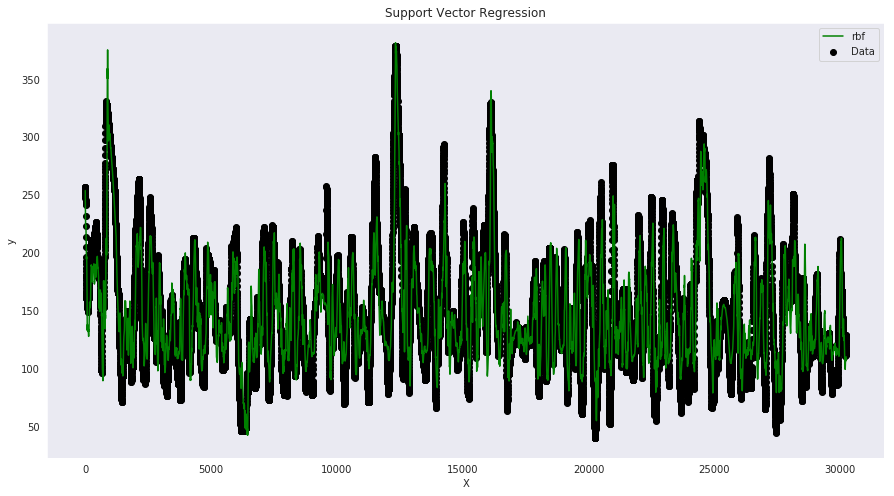

In [170]:
R.plot_training(kernel='rbf')

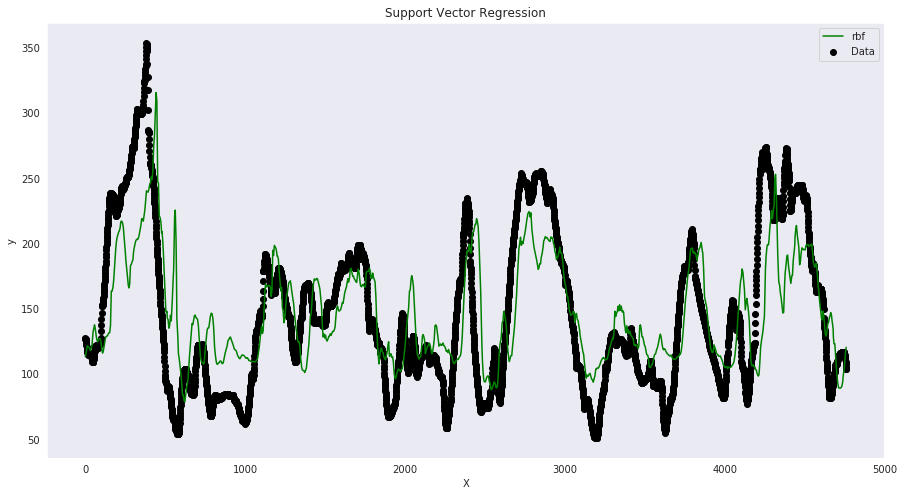

In [182]:
R.plot_test(X=X2, y=y2, kernel='rbf')

In [193]:
R['rbf'].predict(X2)


array([203.86071286, 203.86071286, 203.86071286, ..., 203.86071286,
       203.86071286, 203.86071286])

In [197]:
np.corrcoef([1, 2, 3, 4, 5], [4, 5, 7, 8, np.pi])[0][1]

0.09978585248056746

In [229]:
type(np.array([[1, 2], [3, 4]])) is not np.ndarray

False

In [227]:
len(np.array([1, 2, 3, 4]).shape)

1

In [109]:
proc1['Basal Rate (U/h)'].interpolate(method='pad').count() / len(proc1['Basal Rate (U/h)'].interpolate(method='pad'))

0.44167152130492676

(proc1.loc['2019/02/14 12':'2019/02/15 12']['Bolus Volume Delivered (U)'].dropna()*10).plot()
(proc1.loc['2019/02/14 12':'2019/02/15 12']['BWZ Carb Input (grams)'].dropna()).plot()
(proc1.loc['2019/02/14 12':'2019/02/15 12']['Basal Rate (U/h)'].interpolate(method='pad')*100).plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='linear').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='slinear').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='quadratic').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='cubic').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='spline', order=2).plot()
[
    hybrid_interpolator(proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'], weights=w).plot()
    for w in weights_set
]
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)']
plt.axhline(200, color='red')
plt.axhline(70, color='green')
plt.legend(['Bolus', 'Carbs', 'Basal', 'Linear', 'Slinear', 'Quadratic', 'Cubic', 'spline', *labs, 'Data'])

In [65]:
#overlapping_histograms(proc1, 
 #                      ['Bolus Volume Delivered (U)', 'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)'],
  #                     colors=['red', 'green', 'blue'], 
   #                    labels=('Bolus Wizard Estimation', 'Units', 'Density')
    #                  )

In [66]:
#sb.distplot(dummy['Sensor Glucose (mg/dL)'].dropna())
#sb.distplot(resample_dataframe(dummy)['Sensor Glucose (mg/dL)'].dropna())

In [67]:
dummy2 = resample_dataframe(dummy)

In [69]:
dummy2['2019']

,Basal Rate (U/h),Temp Basal Amount,Bolus Volume Selected (U),Bolus Volume Delivered (U),BWZ Estimate (U),BWZ Carb Ratio (g/U),BWZ Insulin Sensitivity (mg/dL/U),BWZ Carb Input (grams),BWZ BG Input (mg/dL),BWZ Correction Estimate (U),BWZ Food Estimate (U),BWZ Active Insulin (U),Sensor Glucose (mg/dL),BWZ Unabsorbed Insulin Total (U),Final Bolus Estimate
_grouper,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.0,NaN,NaN
2019-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN
2019-01-01 00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
resample_dataframe(dummy).count()

Basal Rate (U/h)                      3510
Temp Basal Amount                       16
Bolus Volume Selected (U)             1252
Bolus Volume Delivered (U)             698
BWZ Estimate (U)                       666
BWZ Carb Ratio (g/U)                   666
BWZ Insulin Sensitivity (mg/dL/U)      666
BWZ Carb Input (grams)                 666
BWZ BG Input (mg/dL)                   666
BWZ Correction Estimate (U)            666
BWZ Food Estimate (U)                  666
BWZ Active Insulin (U)                 666
Sensor Glucose (mg/dL)               79312
BWZ Unabsorbed Insulin Total (U)       666
Final Bolus Estimate                   666
dtype: int64

In [41]:
proc1.count()

Basal Rate (U/h)                      5794
Temp Basal Amount                       16
Bolus Volume Selected (U)             1396
Bolus Volume Delivered (U)             698
BWZ Estimate (U)                       685
BWZ Carb Ratio (g/U)                   685
BWZ Insulin Sensitivity (mg/dL/U)      685
BWZ Carb Input (grams)                 685
BWZ BG Input (mg/dL)                   685
BWZ Correction Estimate (U)            685
BWZ Food Estimate (U)                  685
BWZ Active Insulin (U)                 685
Sensor Glucose (mg/dL)               79322
BWZ Unabsorbed Insulin Total (U)       685
Final Bolus Estimate                   685
dtype: int64

In [37]:
proc1[ proc1['Sensor Glucose (mg/dL)'] == dummy.loc[proc1.index]['Sensor Glucose (mg/dL)'] ]['Sensor Glucose (mg/dL)']

dateTime
2018-06-23 18:32:00    179.0
2018-06-23 18:37:00    176.0
2018-06-23 18:42:00    175.0
2018-06-23 18:47:00    173.0
2018-06-23 18:52:00    178.0
2018-06-23 18:57:00    179.0
2018-06-23 19:02:00    178.0
2018-06-23 19:07:00    176.0
2018-06-23 19:12:00    173.0
2018-06-23 19:17:00    169.0
2018-06-23 19:22:00    165.0
2018-06-23 19:27:00    159.0
2018-06-23 19:32:00    157.0
2018-06-23 19:37:00    160.0
2018-06-23 19:42:00    164.0
2018-06-23 19:47:00    169.0
2018-06-23 19:52:00    171.0
2018-06-23 19:57:00    170.0
2018-06-23 20:02:00    166.0
2018-06-23 20:07:00    161.0
2018-06-23 20:12:00    157.0
2018-06-23 20:17:00    159.0
2018-06-23 20:22:00    159.0
2018-06-23 20:27:00    155.0
2018-06-23 20:32:00    153.0
2018-06-23 20:37:00    147.0
2018-06-23 20:42:00    142.0
2018-06-23 20:47:00    139.0
2018-06-23 20:52:00    142.0
2018-06-23 20:57:00    142.0
                       ...  
2019-04-23 14:51:00    158.0
2019-04-23 14:56:00    152.0
2019-04-23 15:01:00    148.0
2019-

In [477]:
proc1[ proc1['Sensor Glucose (mg/dL)'] != dummy.loc[proc1.index]['Sensor Glucose (mg/dL)'] ]['Sensor Glucose (mg/dL)'].dropna()

dateTime
2019-04-16 09:18:00    182.0
2019-04-16 09:33:00    178.0
2019-04-16 09:38:00    177.0
2019-04-16 09:43:00    177.0
2019-04-16 09:48:00    178.0
2019-04-16 09:53:00    179.0
2019-04-16 09:58:00    182.0
2019-04-16 10:03:00    188.0
2019-04-16 10:08:00    197.0
2019-04-16 10:13:00    204.0
Name: Sensor Glucose (mg/dL), dtype: float64

In [38]:
dummy[ proc1['Sensor Glucose (mg/dL)'] != dummy.loc[proc1.index]['Sensor Glucose (mg/dL)'] ]['Sensor Glucose (mg/dL)'].dropna()

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


ValueError: cannot reindex from a duplicate axis

In [472]:
proc1.loc['2018-06-23 12:08:00']['Sensor Glucose (mg/dL)'], dummy.loc['2018-06-23 12:08:00']['Sensor Glucose (mg/dL)']

(dateTime
 2018-06-23 12:08:00   NaN
 2018-06-23 12:08:00   NaN
 Name: Sensor Glucose (mg/dL), dtype: float64, nan)

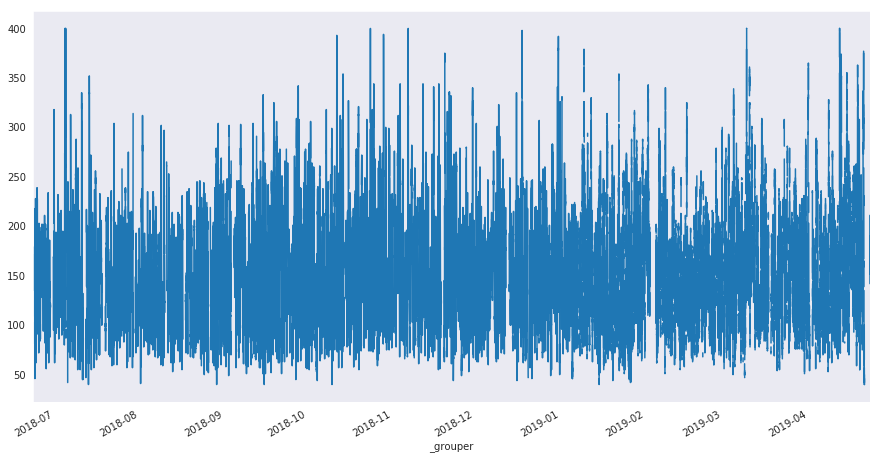

In [426]:
dummy['Sensor Glucose (mg/dL)'].plot()

In [428]:
proc1.duplicated().head()

dateTime
2018-06-23 12:08:00    False
2018-06-23 12:08:00     True
2018-06-23 17:17:00     True
2018-06-23 17:22:00     True
2018-06-23 17:27:00     True
dtype: bool

In [432]:
proc1.loc['2018/06/23 17:27:00']

Basal Rate (U/h)                    NaN
Temp Basal Amount                   NaN
Bolus Volume Selected (U)           NaN
Bolus Volume Delivered (U)          NaN
BWZ Estimate (U)                    NaN
BWZ Carb Ratio (g/U)                NaN
BWZ Insulin Sensitivity (mg/dL/U)   NaN
BWZ Carb Input (grams)              NaN
BWZ BG Input (mg/dL)                NaN
BWZ Correction Estimate (U)         NaN
BWZ Food Estimate (U)               NaN
BWZ Active Insulin (U)              NaN
Sensor Glucose (mg/dL)              NaN
BWZ Unabsorbed Insulin Total (U)    NaN
Final Bolus Estimate                NaN
Name: 2018-06-23 17:27:00, dtype: float64

In [357]:
f"Original index: {len(proc1.index)},\n\
  Original duplicates: {len(proc1.index.get_duplicates())},\n\
  index - duplicates: {len(proc1.index) - len(proc1.index.get_duplicates())},\n\
  merged_index: {len(dummy.index)}, merged_index_duplicates: {len(dummy.index.get_duplicates())}"

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  after removing the cwd from sys.path.


'Original index: 96130,\n  Original duplicates: 5488,\n  index - duplicates: 90642,\n  merged_index: 87519, merged_index_duplicates: 0'

In [360]:
proc1.duplicated()

dateTime
2009-01-01 00:00:00    False
2009-01-01 00:00:00     True
2018-06-23 12:08:00     True
2018-06-23 12:08:00     True
2018-06-23 17:17:00     True
2018-06-23 17:22:00     True
2018-06-23 17:27:00     True
2018-06-23 17:32:00     True
2018-06-23 17:37:00     True
2018-06-23 17:42:00     True
2018-06-23 17:47:00     True
2018-06-23 17:52:00     True
2018-06-23 17:57:00     True
2018-06-23 18:02:00     True
2018-06-23 18:07:00     True
2018-06-23 18:12:00     True
2018-06-23 18:17:00     True
2018-06-23 18:22:00     True
2018-06-23 18:27:00     True
2018-06-23 18:32:00    False
2018-06-23 18:37:00    False
2018-06-23 18:42:00    False
2018-06-23 18:47:00    False
2018-06-23 18:52:00    False
2018-06-23 18:57:00     True
2018-06-23 19:02:00     True
2018-06-23 19:07:00     True
2018-06-23 19:12:00     True
2018-06-23 19:17:00    False
2018-06-23 19:22:00    False
                       ...  
2019-04-23 15:46:00     True
2019-04-23 15:51:00     True
2019-04-23 15:56:00     True
2019-

In [349]:
'2019-04-23 16:27:00' in map(lambda x: str(x), proc1.index.get_duplicates())

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """Entry point for launching an IPython kernel.


True

In [340]:
pd.core.series.Series(sorted(set(proc1.index))) == proc1.index

ValueError: Lengths must match

In [332]:
df  = proc1.replace(np.nan, '').ffill().bfill()
df_ = df.replace('', np.nan).ffill().bfill()

In [333]:
pd.concat([
        df_[df_.duplicated()],
        df.loc[df_.drop_duplicates(keep=False).index]
    ])

,Basal Rate (U/h),Temp Basal Amount,Bolus Volume Selected (U),Bolus Volume Delivered (U),BWZ Estimate (U),BWZ Carb Ratio (g/U),BWZ Insulin Sensitivity (mg/dL/U),BWZ Carb Input (grams),BWZ BG Input (mg/dL),BWZ Correction Estimate (U),BWZ Food Estimate (U),BWZ Active Insulin (U),Sensor Glucose (mg/dL),BWZ Unabsorbed Insulin Total (U),Final Bolus Estimate
dateTime,,,,,,,,,,,,,,,
2009-01-01 00:00:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05
2018-06-23 12:08:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05
2018-06-23 12:08:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05
2018-06-23 17:17:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05
2018-06-23 17:22:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05
2018-06-23 17:27:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05
2018-06-23 17:32:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05
2018-06-23 17:37:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05
2018-06-23 17:42:00,0.78,125,6.05,6.05,6.05,13,66,79,0,0,6.05,0,179,0,6.05


In [334]:
proc1.resample('1T').asfreq()

ValueError: cannot reindex from a duplicate axis

In [328]:
resampled1 = resample_dataframe(proc1)

KeyboardInterrupt: 

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(p

In [322]:
proc1.index

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 00:00:00',
               '2018-06-23 12:08:00', '2018-06-23 12:08:00',
               '2018-06-23 17:17:00', '2018-06-23 17:22:00',
               '2018-06-23 17:27:00', '2018-06-23 17:32:00',
               '2018-06-23 17:37:00', '2018-06-23 17:42:00',
               ...
               '2019-04-23 16:41:00', '2019-04-23 16:46:00',
               '2019-04-23 16:51:00', '2019-04-23 16:56:00',
               '2019-04-23 17:00:00', '2019-04-23 17:00:00',
               '2019-04-23 17:01:00', '2019-04-23 17:06:00',
               '2019-04-23 17:11:00', '2019-04-23 17:16:00'],
              dtype='datetime64[ns]', name='dateTime', length=96130, freq=None)

In [323]:
proc1.index.map(lambda t: t.replace(second=0))

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 00:00:00',
               '2018-06-23 12:08:00', '2018-06-23 12:08:00',
               '2018-06-23 17:17:00', '2018-06-23 17:22:00',
               '2018-06-23 17:27:00', '2018-06-23 17:32:00',
               '2018-06-23 17:37:00', '2018-06-23 17:42:00',
               ...
               '2019-04-23 16:41:00', '2019-04-23 16:46:00',
               '2019-04-23 16:51:00', '2019-04-23 16:56:00',
               '2019-04-23 17:00:00', '2019-04-23 17:00:00',
               '2019-04-23 17:01:00', '2019-04-23 17:06:00',
               '2019-04-23 17:11:00', '2019-04-23 17:16:00'],
              dtype='datetime64[ns]', name='dateTime', length=96130, freq=None)

In [324]:
proc1.iloc[0:20, :]

,Basal Rate (U/h),Temp Basal Amount,Bolus Volume Selected (U),Bolus Volume Delivered (U),BWZ Estimate (U),BWZ Carb Ratio (g/U),BWZ Insulin Sensitivity (mg/dL/U),BWZ Carb Input (grams),BWZ BG Input (mg/dL),BWZ Correction Estimate (U),BWZ Food Estimate (U),BWZ Active Insulin (U),Sensor Glucose (mg/dL),BWZ Unabsorbed Insulin Total (U),Final Bolus Estimate
dateTime,,,,,,,,,,,,,,,
2009-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-23 12:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-23 12:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-23 17:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-23 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-23 17:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-23 17:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-23 17:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [326]:
resampled1.iloc[25:40, :]

,Basal Rate (U/h),Temp Basal Amount,Bolus Volume Selected (U),Bolus Volume Delivered (U),BWZ Estimate (U),BWZ Carb Ratio (g/U),BWZ Insulin Sensitivity (mg/dL/U),BWZ Carb Input (grams),BWZ BG Input (mg/dL),BWZ Correction Estimate (U),BWZ Food Estimate (U),BWZ Active Insulin (U),Sensor Glucose (mg/dL),BWZ Unabsorbed Insulin Total (U),Final Bolus Estimate
dateTime,,,,,,,,,,,,,,,
2009-01-01 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
len(proc1['Basal Rate (U/h)']), proc1['Basal Rate (U/h)'].count()

(96130, 5794)

In [20]:
#with sb.axes_style('white'):
 #   sb.jointplot('Bolus Volume Delivered (U)', 'BWZ Correction Estimate (U)', raw[['Bolus Volume Delivered (U)', 'BWZ Correction Estimate (U)']].dropna(), kind='hex')

In [21]:
len(proc1['2019']['Basal Rate (U/h)']), proc1['2019']['Basal Rate (U/h)'].interpolate(method='pad').count()

(43711, 42457)

In [262]:
mean, std, dev, _avg_dev_mean = dev_from_mean(proc1['Sensor Glucose (mg/dL)'])
mean, std, _avg_dev_mean

(154.36552280577897, 55.004304897107545, 43.5559281376726)

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


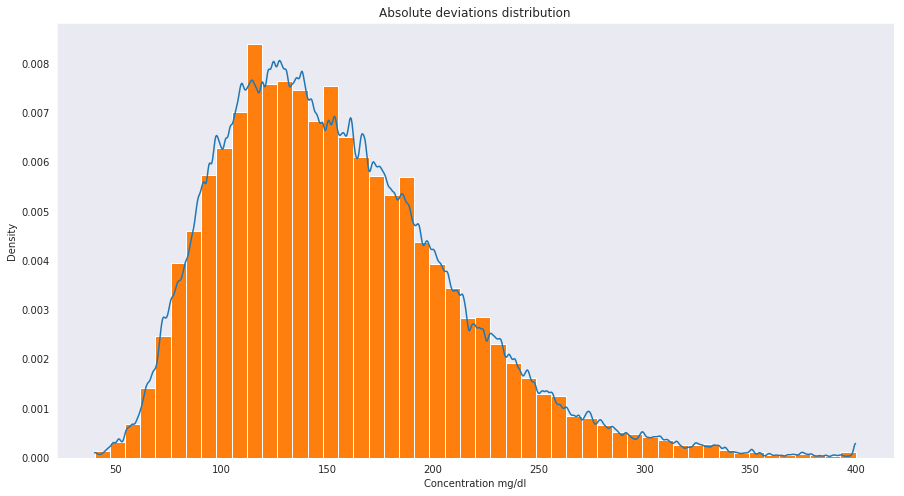

0.9599560951297901

In [260]:
x = proc1['Sensor Glucose (mg/dL)']
probability_estimate(x, 
                     x.mean() - 2*x.std(), 
                     x.mean() + 2*x.std(),
                     N=500, 
                     show_plots=True
                    )

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


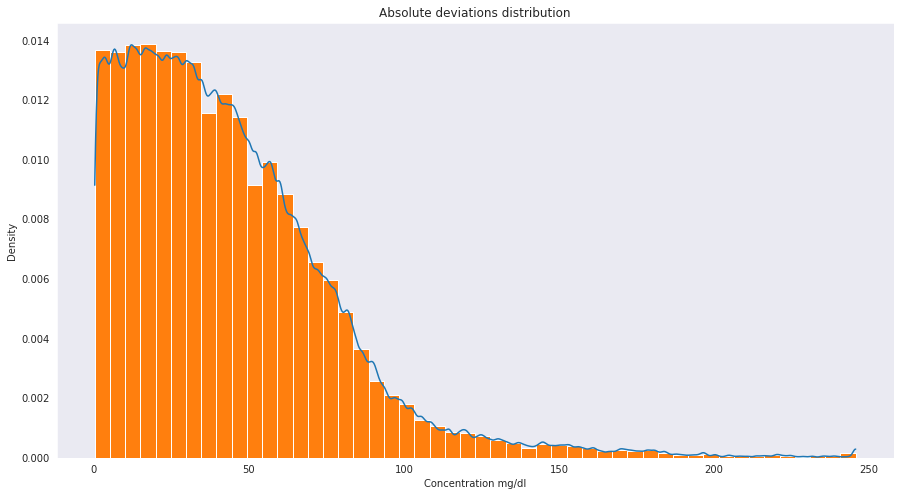

0.8788810832262138

In [263]:
probability_estimate(dev, 0, 80, N=500, show_plots=True)

In [235]:
weights_set = [ 
    [0.1, 0.9], 
    [0.2, 0.8],
    [0.3, 0.7],
    [0.4, 0.6],
    [0.5, 0.5],
    [0.6, 0.4],
    [0.7, 0.3],
    [0.8, 0.2],
    [0.9, 0.1]
]
labs = [f'Corrected hybrid {weight}' for weight in weights_set]

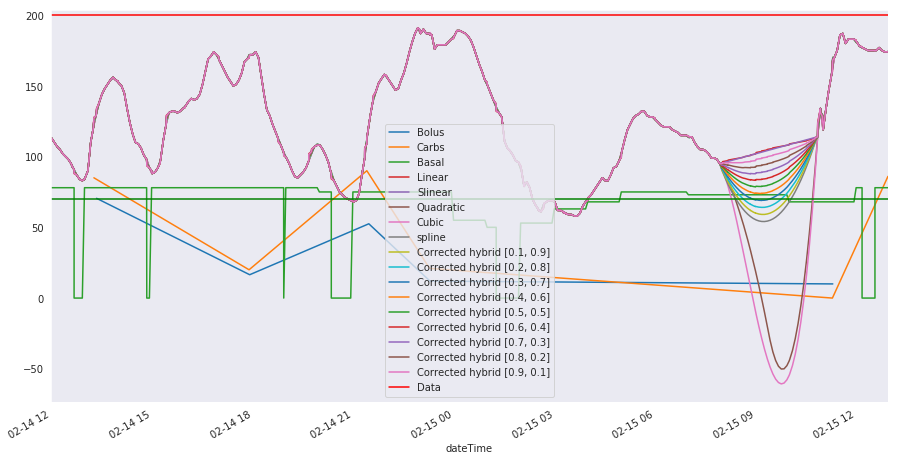

In [265]:
(proc1.loc['2019/02/14 12':'2019/02/15 12']['Bolus Volume Delivered (U)'].dropna()*10).plot()
(proc1.loc['2019/02/14 12':'2019/02/15 12']['BWZ Carb Input (grams)'].dropna()).plot()
(proc1.loc['2019/02/14 12':'2019/02/15 12']['Basal Rate (U/h)'].interpolate(method='pad')*100).plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='linear').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='slinear').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='quadratic').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='cubic').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='spline', order=2).plot()
[
    hybrid_interpolator(proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'], weights=w).plot()
    for w in weights_set
]
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)']
plt.axhline(200, color='red')
plt.axhline(70, color='green')
plt.legend(['Bolus', 'Carbs', 'Basal', 'Linear', 'Slinear', 'Quadratic', 'Cubic', 'spline', *labs, 'Data'])

In [237]:
test_day = copy.deepcopy(proc1.loc['2019/02/14 12':'2019/02/14 22']['Sensor Glucose (mg/dL)'])
gap1 = copy.deepcopy(test_day)
gap2 = copy.deepcopy(test_day)

In [266]:
proc2 = proc1.loc['2019/02/05':'2019/04/23']

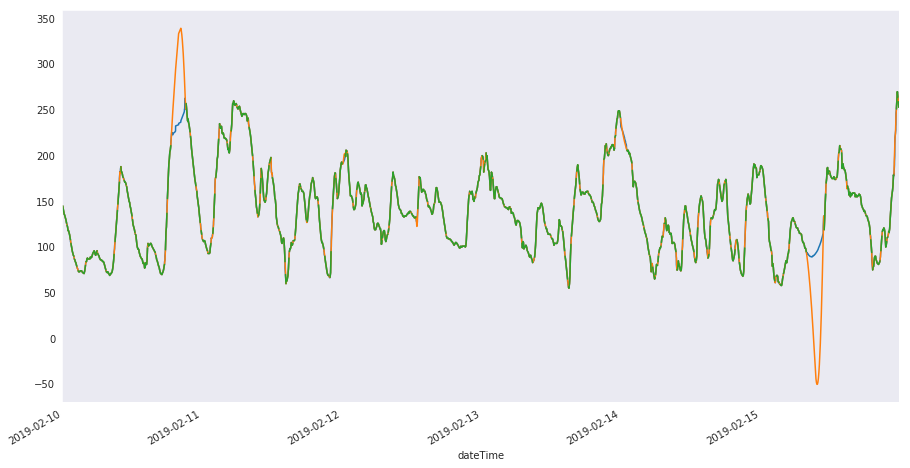

In [132]:
hybrid_interpolator(proc2.loc['2019/02/10':'2019/02/15']['Sensor Glucose (mg/dL)']).plot()
proc2.loc['2019/02/10':'2019/02/15']['Sensor Glucose (mg/dL)'].interpolate(method='polynomial', order=2).plot()
proc2.loc['2019/02/10':'2019/02/15']['Sensor Glucose (mg/dL)'].plot()


In [133]:
list(filter(lambda x: not x, sorted(proc2.index) == proc2.index))

[]

In [134]:
df = copy.deepcopy(test_day)
x = df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum()
#x

In [238]:
gap1.loc['2019/02/14 20:00':'2019/02/14 20:30'] = np.nan
gap2.loc['2019/02/14 13:45':'2019/02/14 14:25'] = np.nan
#gap1.loc['2019/02/14 17:45':'2019/02/14 18:15'] = np.nan

In [137]:
hybrid_proc1 = hybrid_interpolator(proc1.loc['2019/01':'2019/03']['Sensor Glucose (mg/dL)'])
linear_proc1 = proc1.loc['2019/01':'2019/03']['Sensor Glucose (mg/dL)'].interpolate(method='linear', limit_direction='both')
#proc1.loc['2019/01':'2019/03']['Sensor Glucose (mg/dL)'].rolling(2).mean().plot()
#proc1.loc['2019/01':'2019/03']['Sensor Glucose (mg/dL)']
#plt.legend(['Hybrid interpolator', 'Linear', 'Data'])

In [143]:
dates: list = []
for i in range(1, 4):
    for j in range(1, 28):
        if j < 10:
            dates.append(f'2019/0{i}/0{j}')
        else:
            dates.append(f'2019/0{i}/{j}')

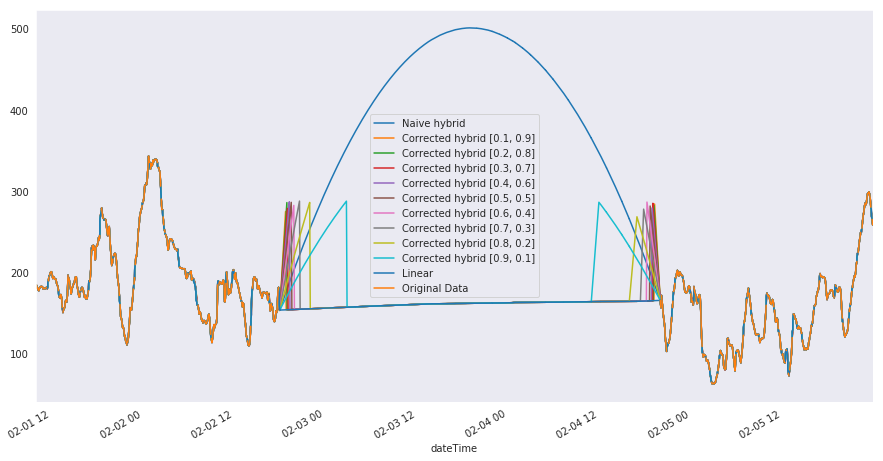

In [234]:
naive_hybrid_interpolator(proc1.loc['2019/02/01 10':'2019/02/05 23']['Sensor Glucose (mg/dL)']).plot()
[
    hybrid_interpolator(proc1.loc['2019/02/01 10':'2019/02/05 23']['Sensor Glucose (mg/dL)'], weights=w).plot()
    for w in weights_set
]
proc1.loc['2019/02/01 10':'2019/02/05 23']['Sensor Glucose (mg/dL)'].interpolate(method='linear').plot()
proc1.loc['2019/02/01 10':'2019/02/05 23']['Sensor Glucose (mg/dL)'].plot()
plt.legend(['Naive hybrid', *labs, 'Linear', 'Original Data'])

In [282]:
proc1.loc['2019/03/01':'2019/03/08']['Sensor Glucose (mg/dL)'].count() / len(proc1.loc['2019/03/01':'2019/03/08']['Sensor Glucose (mg/dL)'])

0.6826833073322933

In [288]:
porcentage_original(proc1['Sensor Glucose (mg/dL)'], proc1.index[0], proc1.index[-1]), porcentage_interpolated(proc1['Sensor Glucose (mg/dL)'], proc1.index[0], proc1.index[-1])

(0.8251534380526371, 0.17484656194736292)

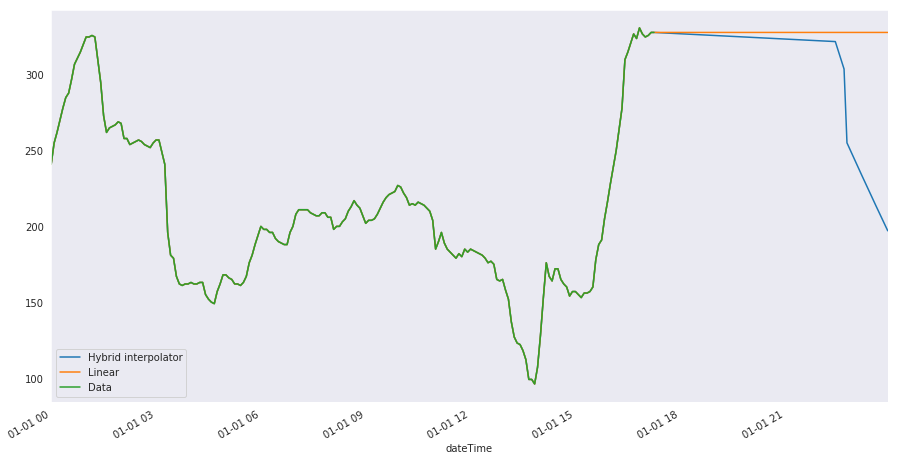

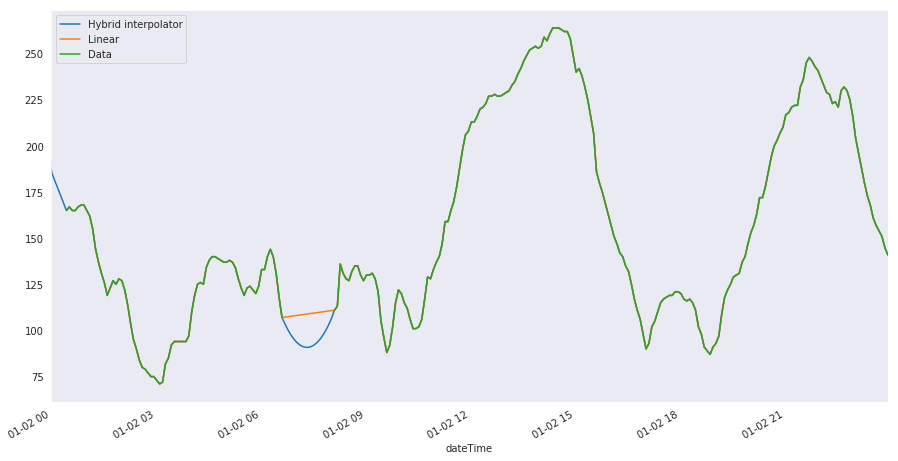

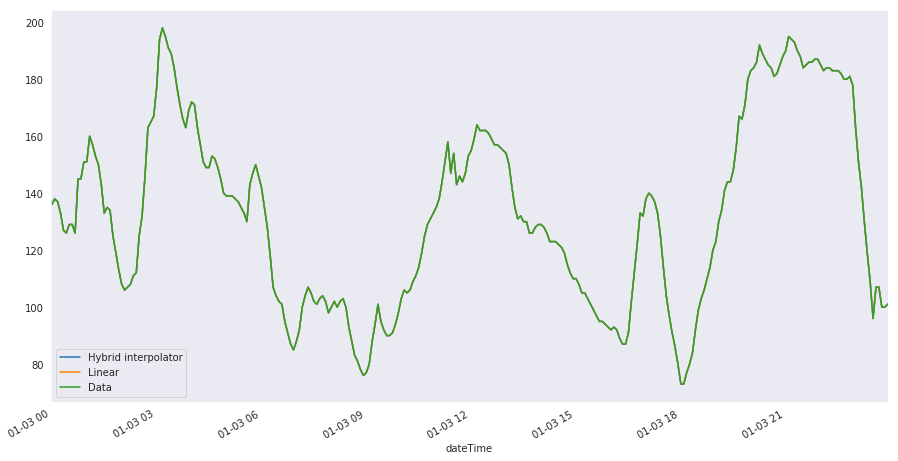

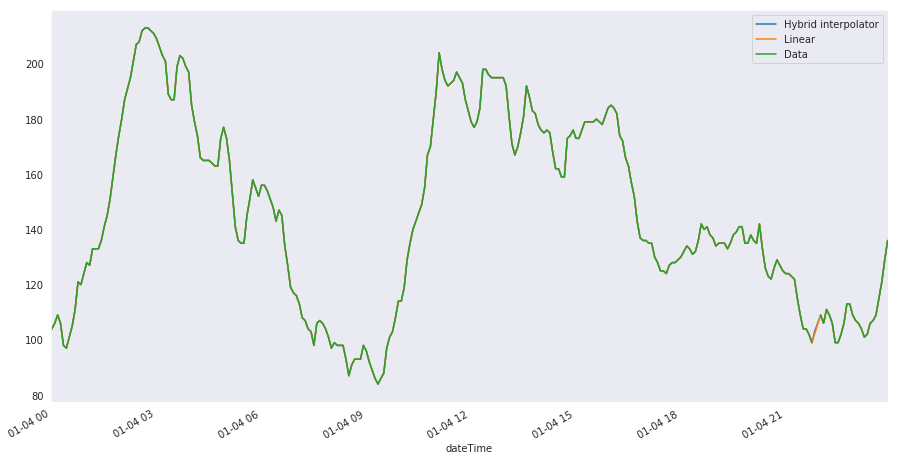

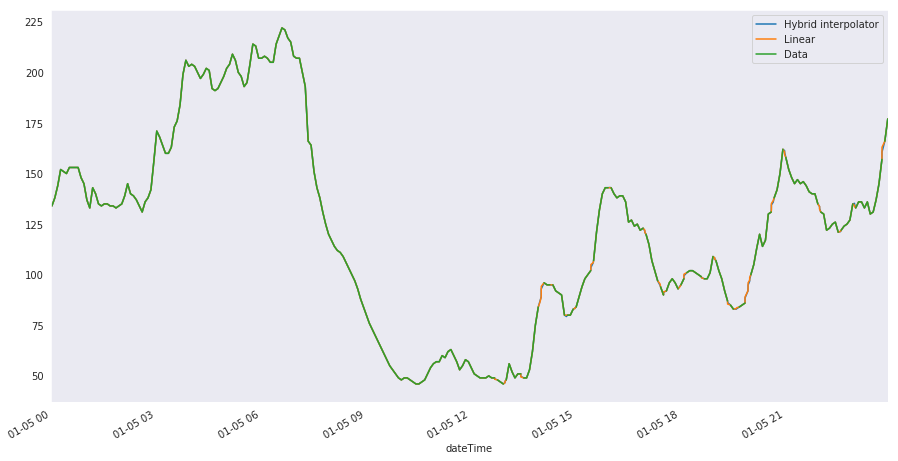

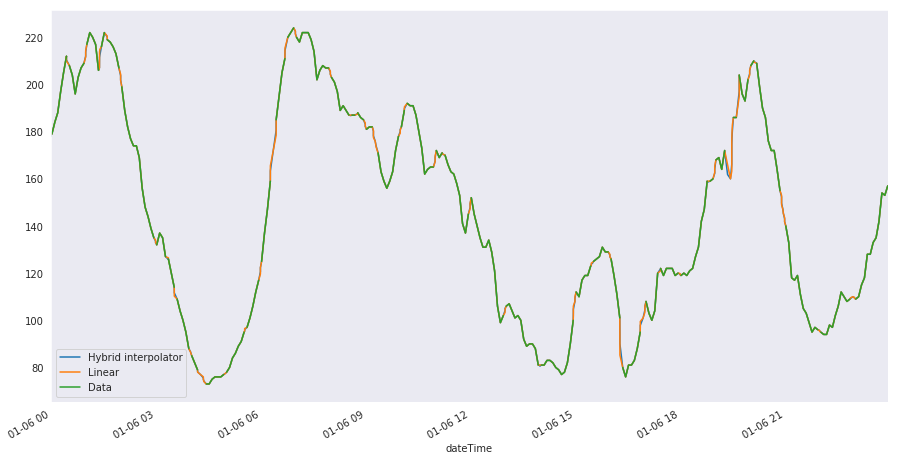

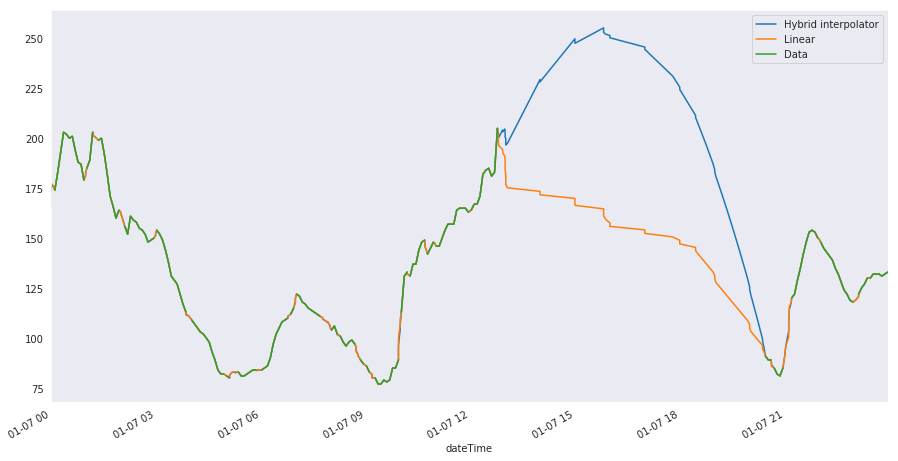

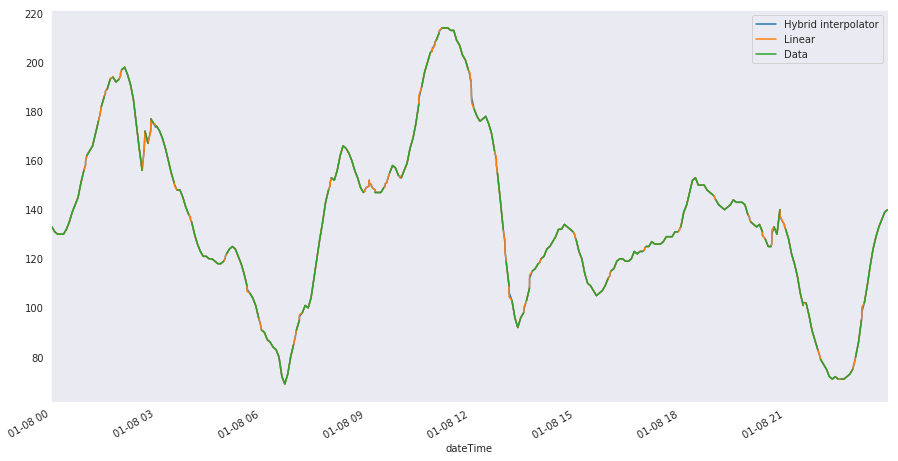

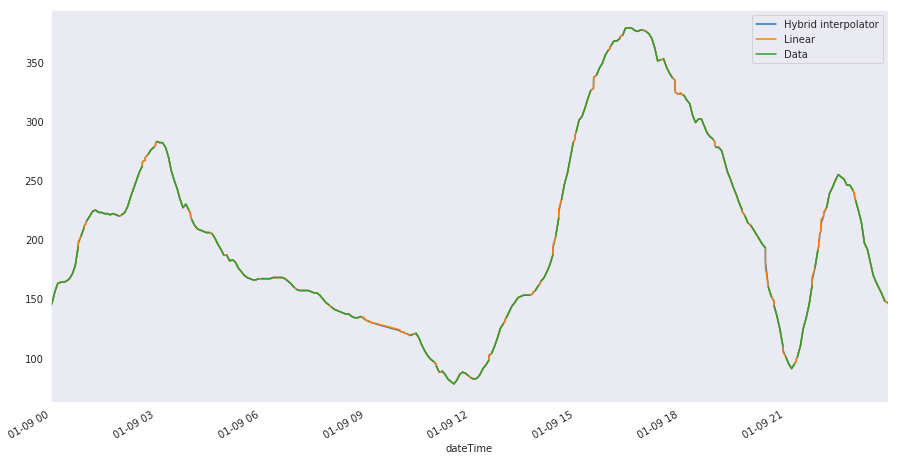

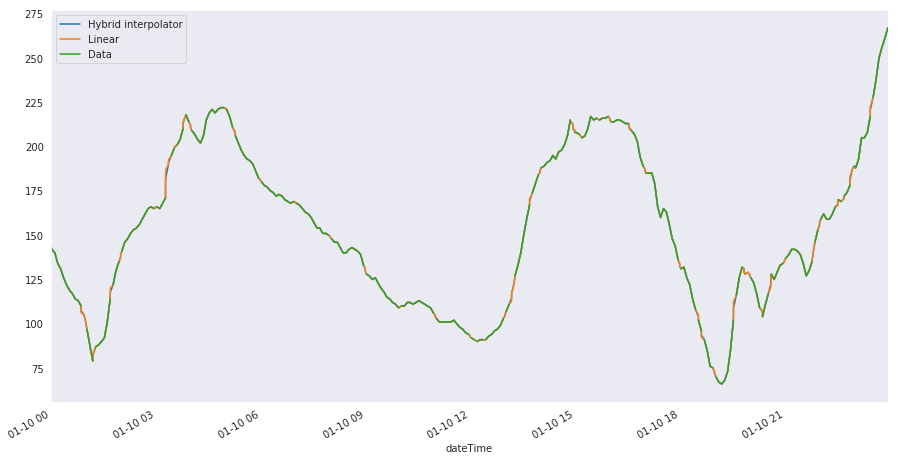

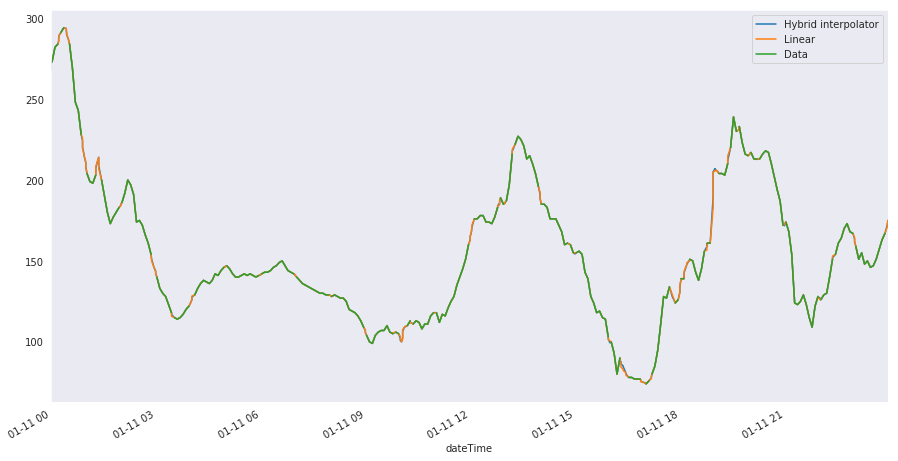

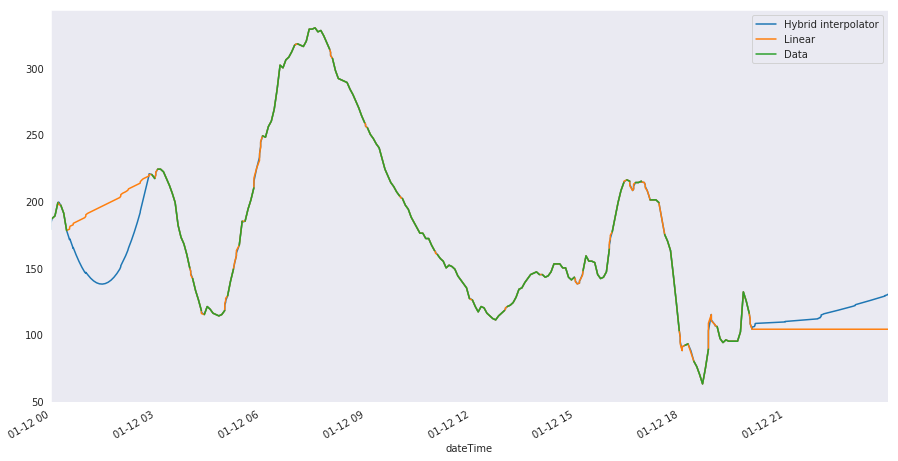

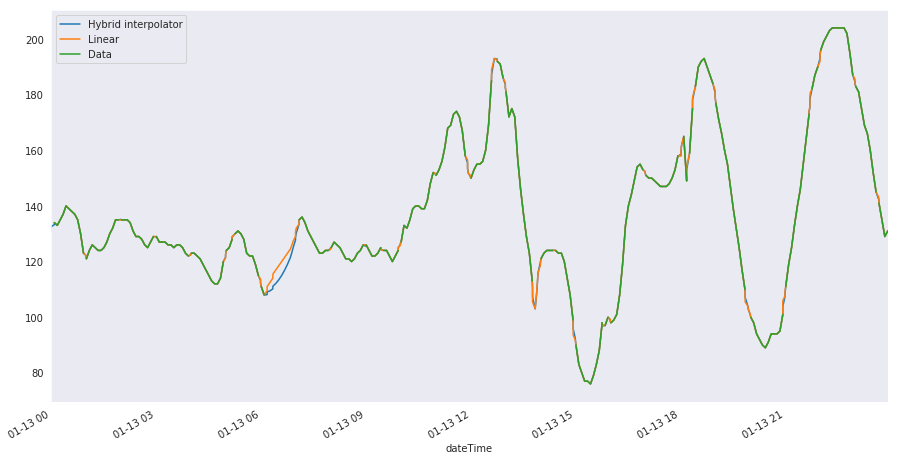

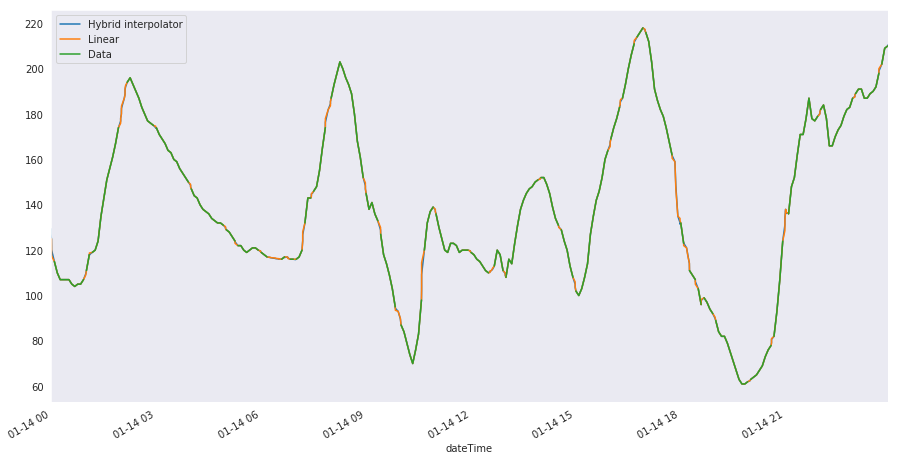

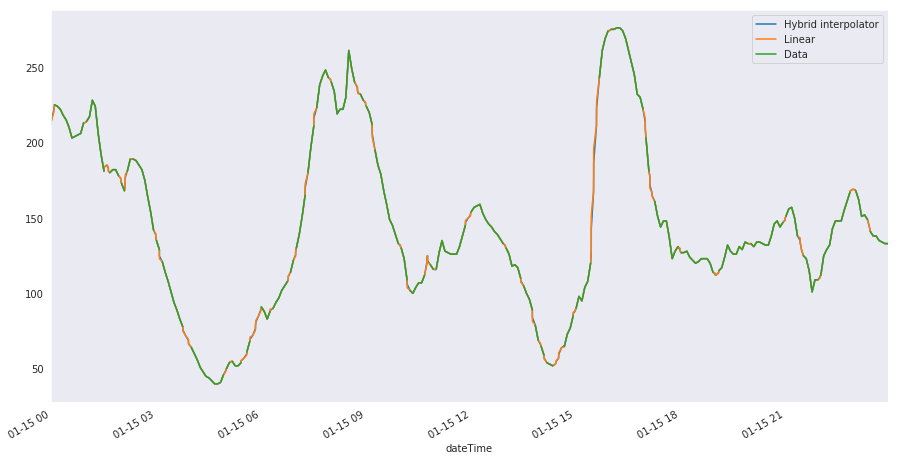

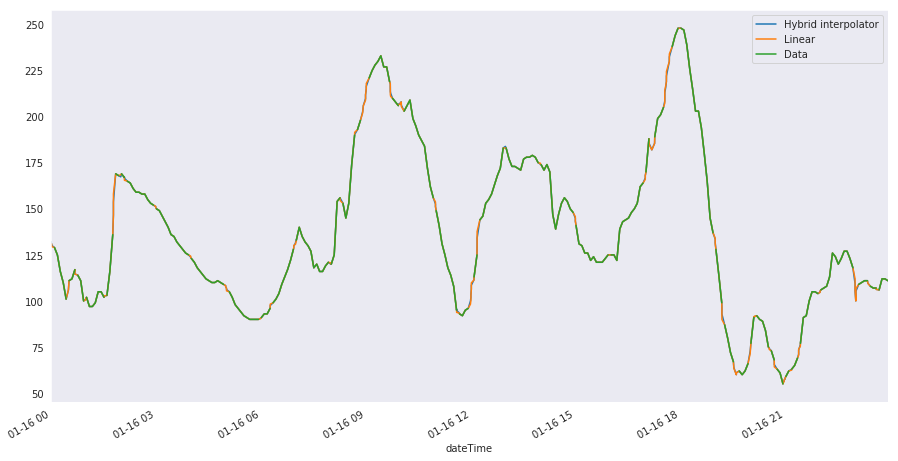

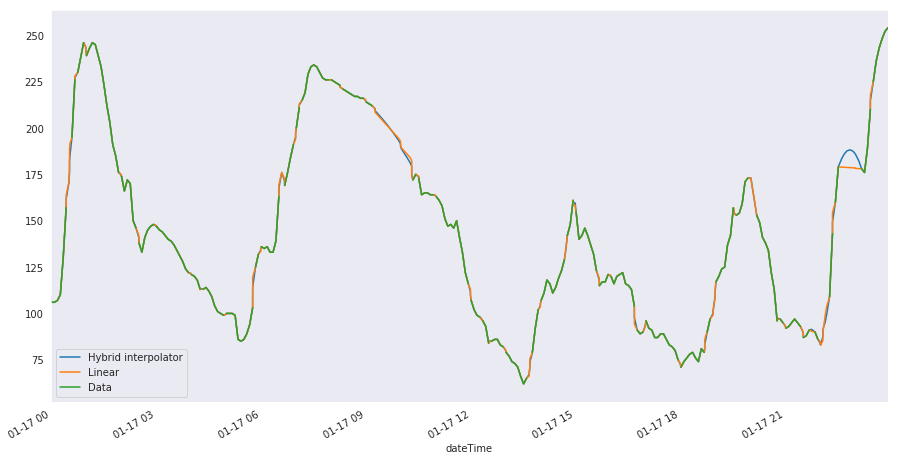

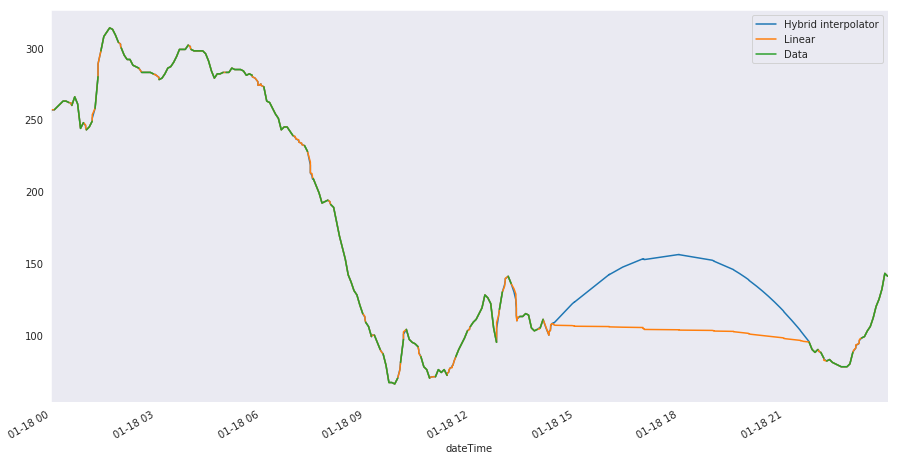

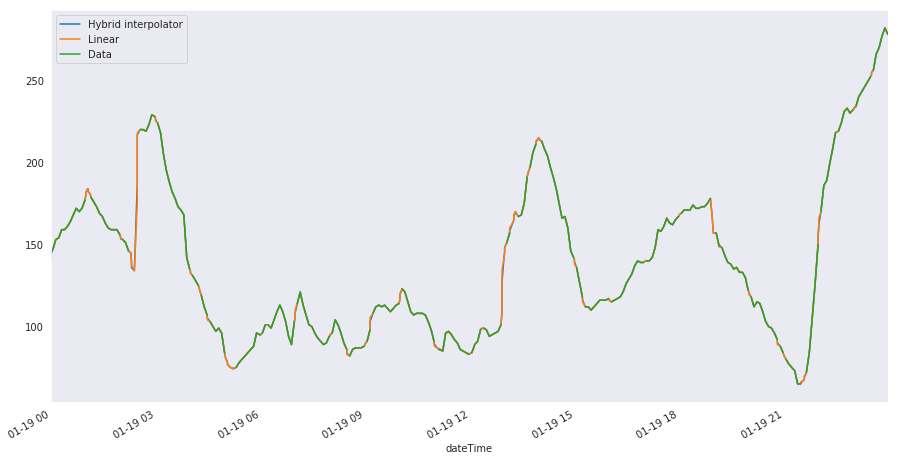

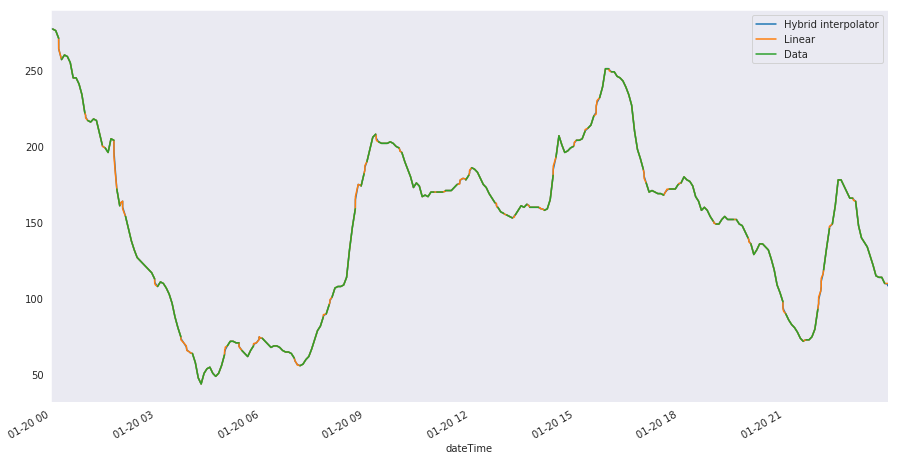

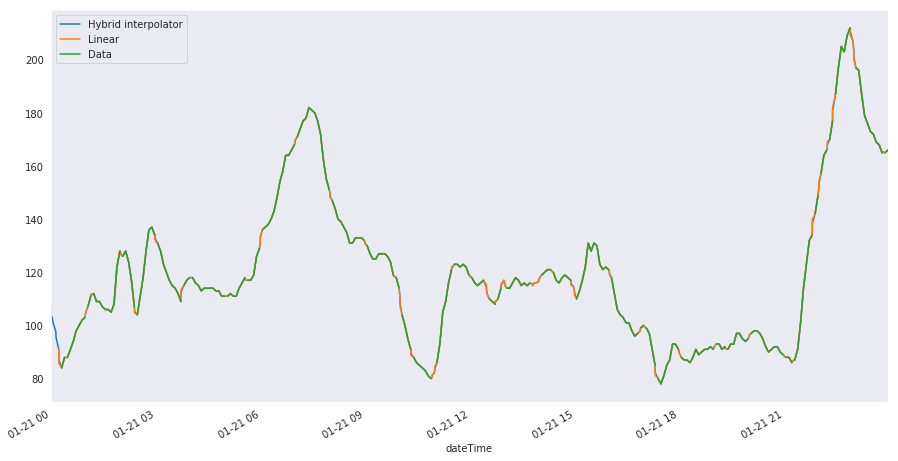

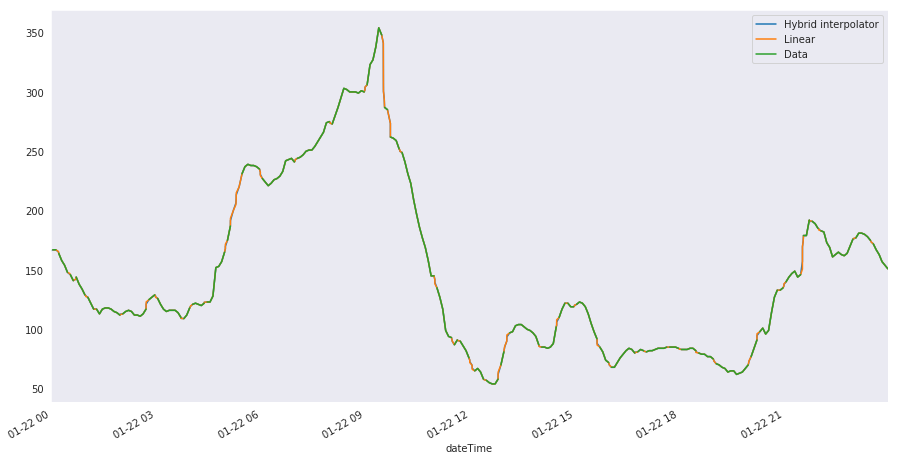

KeyboardInterrupt: 

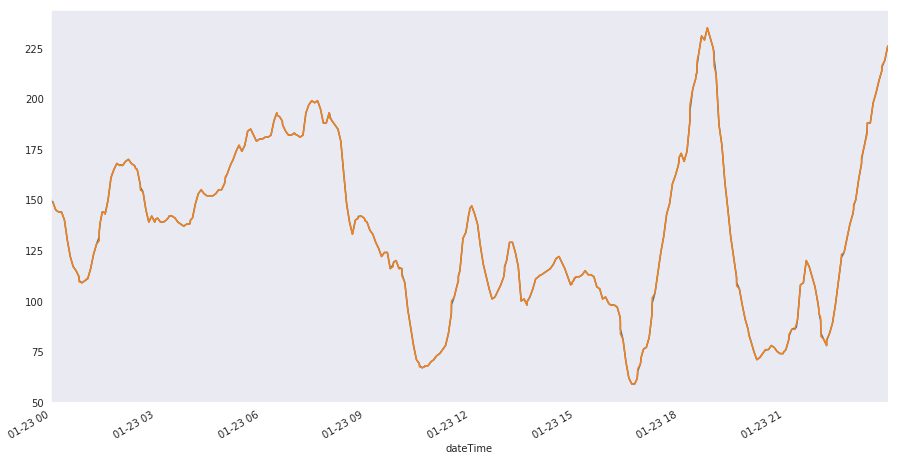

Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gml/anaconda3/envs/DiabManager/lib/python3.6/multiprocessing/process.py", line 93, i

In [148]:
for date in dates:
    hybrid_proc1[date].plot()
    proc1.loc[date]['Sensor Glucose (mg/dL)'].interpolate(method='linear').plot()
    proc1.loc[date]['Sensor Glucose (mg/dL)'].plot()
    plt.legend(['Hybrid interpolator', 'Linear', 'Data'])
    plt.show()

In [149]:
#for i in pd.date_range(pd.to_datetime('2019/01/10'), periods=60).tolist():
 #   hybrid_interpolator(proc1.loc[i]['Sensor Glucose (mg/dL)']).plot()
  #  proc1.loc[i]['Sensor Glucose (mg/dL)'].plot()

In [151]:
#hybrid_interpolator(proc1.loc['2019/02/05']['Sensor Glucose (mg/dL)']).plot()
#proc1.loc['2019/02/05']['Sensor Glucose (mg/dL)'].plot()

In [152]:
#proc1.loc['2019/03/05 03':'2019/03/05 07']['Sensor Glucose (mg/dL)'].interpolate(method='linear').plot()
#hybrid_interpolator(proc1.loc['2019/03/05 03':'2019/03/05 07']['Sensor Glucose (mg/dL)']).plot()
#proc1.loc['2019/03/05 03':'2019/03/05 07']['Sensor Glucose (mg/dL)'].plot()

In [153]:
#proc1.iloc[0, :], proc1.iloc[len(proc1.index)-1, :]

In [154]:
#with open('dateTime.txt', 'w') as f:
#    for i in raw['dateTime']:
#        f.write(f'{i}\n')

In [156]:
'''
list(
    map(
        type, list(raw[ raw['Sensor Glucose (mg/dL)'].notnull() ]['Sensor Glucose (mg/dL)'])
    )
)
'''

"\nlist(\n    map(\n        type, list(raw[ raw['Sensor Glucose (mg/dL)'].notnull() ]['Sensor Glucose (mg/dL)'])\n    )\n)\n"

In [157]:
#glucosas = raw[ raw['Sensor Glucose (mg/dL)'].notnull() ]['Sensor Glucose (mg/dL)']

In [158]:
#glucosas = pd.to_numeric(glucosas, 'coerce')

In [ ]:
#glucosas = glucosas[glucosas == glucosas // 1]

In [160]:
#sb.distplot(glucosas)

In [176]:
proporciones = (lambda glucosas, borne_inf, borne_sup1, borne_sup2: 
                { 
                    'hypo': (f'x <= {borne_inf}', 100 * glucosas[glucosas <= borne_inf].count() / glucosas.count()),
                    'normo': (f'{borne_inf} < x <= {borne_sup1}', 100 * glucosas[(glucosas > borne_inf) & (glucosas <=borne_sup1)].count() / glucosas.count()),
                    'hyper': (f'x > {borne_sup1}', 100 * glucosas[glucosas > borne_sup1].count() / glucosas.count()),
                    'hyper2': (f'x > {borne_sup2}', 100 * glucosas[glucosas > borne_sup2].count() / glucosas.count()),
                }
)(proc1['Sensor Glucose (mg/dL)'], 70, 140, 180)

In [177]:
proporciones

{'hypo': ('x <= 70', 2.2137616298126623),
 'normo': ('70 < x <= 140', 43.63354428783944),
 'hyper': ('x > 140', 54.1526940823479),
 'hyper2': ('x > 180', 28.37296084314566)}

In [168]:
#raw.iloc[0,:], raw.iloc[len(raw.index)-1, :]
#data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
#data = pd.DataFrame(data, columns=['x', 'y'])
#data

In [96]:
'''
glucosas = filter(lambda x: x if not np.isnan(x) else False,
                  list(
                    map(int, glucosas)
                    )
            )
#Value error: cannot convert float NaN to integer
'''    

'\nglucosas = filter(lambda x: x if not np.isnan(x) else False,\n                  list(\n                    map(int, glucosas)\n                    )\n            )\n#Value error: cannot convert float NaN to integer\n'

In [279]:
len(proc2.loc['2019/02/02':'2019/02/05']), len(proc2.loc['2019/02/02':'2019/02/05'].resample('1T').mean())

(413, 1440)

In [254]:
proc1[ proc1['Sensor Glucose (mg/dL)'] == 140 ]

,Basal Rate (U/h),Temp Basal Amount,Bolus Volume Selected (U),Bolus Volume Delivered (U),BWZ Estimate (U),BWZ Carb Ratio (g/U),BWZ Insulin Sensitivity (mg/dL/U),BWZ Carb Input (grams),BWZ BG Input (mg/dL),BWZ Correction Estimate (U),BWZ Food Estimate (U),BWZ Active Insulin (U),Sensor Glucose (mg/dL),BWZ Unabsorbed Insulin Total (U),Final Bolus Estimate
dateTime,,,,,,,,,,,,,,,
2018-06-23 21:12:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-24 04:22:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-24 10:57:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-25 07:22:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 09:57:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 17:27:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 17:32:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 17:37:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 17:42:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
